# Image Classification

Preprocessing -> Feature Extraction -> Training

In [ ]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
dataset_dir = '/content/drive/My Drive/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

## Metode preprocessing

In [ ]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

# Feature Extraction

In [ ]:
# From: https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

In [ ]:
# From: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

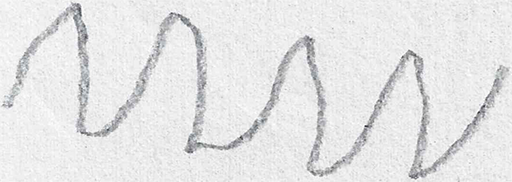

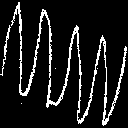

HOG
[0. 0. 0. ... 0. 0. 0.] 4356
LBP
[9.27734375e-03 3.35693359e-02 1.77001953e-03 3.05175781e-04
 1.22070312e-04 1.22070312e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.97155762e-01 5.76782227e-02] 26


In [ ]:
#Testing image

image_test = cv.imread('/content/drive/My Drive/parkinsons/wave/training/parkinson/V02PO02.png')

image_test_preprocessed = preprocess(image_test, image_size=128)

cv2_imshow(image_test)
cv2_imshow(image_test_preprocessed)

features_hog = quantify_image_hog(image_test_preprocessed)
features_lbp = quantify_image_lbp(image_test_preprocessed)

print('HOG')
print(features_hog, len(features_hog))
print('LBP')
print(features_lbp, len(features_lbp))

# Split dataset

In [ ]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

# HOG sz image 128

In [ ]:
resize_128 = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_128, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_128, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
label_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.67
F1 0.6651785714285714
Precision 0.6696832579185521
Recall 0.6666666666666666


In [ ]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.get_params()

lin_svc = LinearSVC(penalty='l2', loss='hinge', random_state=10)
lin_svc.fit(feature_train, label_train)
prediksi_lin_svc_test = lin_svc.predict(feature_test)

cm = confusion_matrix(label_test, prediksi_lin_svc_test)
cr = classification_report(label_test, prediksi_lin_svc_test)

print('Accuracy of SVM on test set: {:.2f}'.format(lin_svc.score(feature_test, label_test)))
print('F1 {:.2f}'.format(f1_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Precision{:.2f}'.format(precision_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Recall {:.2f}'.format(recall_score(label_test, prediksi_lin_svc_test, average='macro')))
print()
print(cr)
print(cm)

Accuracy of SVM on test set: 0.73
F1 0.73
Precision0.74
Recall 0.73

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.77      0.67      0.71        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30

[[12  3]
 [ 5 10]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0          10   5   15
1           3  12   15
All        13  17   30


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.71      0.80      0.75        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30

Accuracy of Random Forest on test set: 0.73
F1 0.7321428571428572
Precision 0.7375565610859729
Recall 0.7333333333333334


# LBP sz image 128

In [ ]:
resize_128 = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'lbp' # 'lbp' atau 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_128, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_128, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
label_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.50
F1 0.4994438264738599
Precision 0.5
Recall 0.5


In [ ]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.get_params()

lin_svc = LinearSVC(penalty='l2', loss='hinge', random_state=10)
lin_svc.fit(feature_train, label_train)
prediksi_lin_svc_test = lin_svc.predict(feature_test)

cm = confusion_matrix(label_test, prediksi_lin_svc_test)
cr = classification_report(label_test, prediksi_lin_svc_test)

print('Accuracy of SVM on test set: {:.2f}'.format(lin_svc.score(feature_test, label_test)))
print('F1 {:.2f}'.format(f1_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Precision{:.2f}'.format(precision_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Recall {:.2f}'.format(recall_score(label_test, prediksi_lin_svc_test, average='macro')))
print()
print(cr)
print(cm)

Accuracy of SVM on test set: 0.60
F1 0.569377990430622
Precision 0.639751552795031
Recall 0.6


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           8   7   15
1           8   7   15
All        16  14   30


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.50      0.47      0.48        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.50      0.50      0.50        30

Accuracy of Random Forest on test set: 0.50
F1 0.4994438264738599
Precision 0.5
Recall 0.5


# HOG sz image 300

In [ ]:
resize_300 = 300 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_300, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_300, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
label_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


In [ ]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.get_params()

lin_svc = LinearSVC(penalty='l2', loss='hinge', random_state=10)
lin_svc.fit(feature_train, label_train)
prediksi_lin_svc_test = lin_svc.predict(feature_test)

cm = confusion_matrix(label_test, prediksi_lin_svc_test)
cr = classification_report(label_test, prediksi_lin_svc_test)

print('Accuracy of SVM on test set: {:.2f}'.format(lin_svc.score(feature_test, label_test)))
print('F1 {:.2f}'.format(f1_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Precision{:.2f}'.format(precision_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Recall {:.2f}'.format(recall_score(label_test, prediksi_lin_svc_test, average='macro')))
print()
print(cr)
print(cm)

Accuracy of SVM on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0          10   5   15
1           4  11   15
All        14  16   30


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

Accuracy of Random Forest on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


# LBP sz image 300

In [ ]:
resize_300 = 300 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'lbp' # 'lbp' atau 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_300, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_300, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
label_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.53
F1 0.5333333333333333
Precision 0.5333333333333333
Recall 0.5333333333333333


In [ ]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.get_params()

lin_svc = LinearSVC(penalty='l2', loss='hinge', random_state=10)
lin_svc.fit(feature_train, label_train)
prediksi_lin_svc_test = lin_svc.predict(feature_test)

cm = confusion_matrix(label_test, prediksi_lin_svc_test)
cr = classification_report(label_test, prediksi_lin_svc_test)

print('Accuracy of SVM on test set: {:.2f}'.format(lin_svc.score(feature_test, label_test)))
print('F1 {:.2f}'.format(f1_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Precision{:.2f}'.format(precision_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Recall {:.2f}'.format(recall_score(label_test, prediksi_lin_svc_test, average='macro')))
print()
print(cr)
print(cm)

Accuracy of SVM on test set: 0.50
F1 0.33
Precision0.25
Recall 0.50

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       0.00      0.00      0.00        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30

[[15  0]
 [15  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           9   6   15
1           4  11   15
All        13  17   30


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.65      0.73      0.69        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30

Accuracy of Random Forest on test set: 0.67
F1 0.6651785714285714
Precision 0.6696832579185521
Recall 0.6666666666666666
